In [124]:
# import sys
# !{sys.executable} -m pip install qutip
import numpy as np
import matplotlib.pyplot as plt
from arc import *  # Import ARC (Alkali Rydberg Calculator)
from qutip import *
from scipy.fft import fft, ifft
from scipy import constants 
from Alk_atom import alk_atom
from PIL import Image

In [125]:
# Here is the Class alk_atom created by Maimouna Bocoum - 01-08-2023
class alk_atom:
    def __init__(self,myList:list):
        # test the type of the list and trck error
        #try:
            self.MakeAtomFromList(myList)

        # except:
        #     print("error in construction format inpout. exemple of acceptable inpout: [ [0,[3,4]] , [1,[3,4]] ]")
        # pass

    def AddLeveltoList(self,Level:list):
          # Level exemple of list structure: [0,[1,2]], for l=0 ; F=1 and F=2
        self.LevelList.append(Level)
        self.MakeAtomFromList()
        
    def MakeAtomFromList(self,myList):
            N = len(myList)
            self.LevelList = myList
            self.F = []
            self.L = []
            self.J = []
            self.M = []

            for loop in range(0,N):
                Line = myList[loop]  # get l orbital number. l=0 for 6S1/2 , l=1 for 6P1/2 and 6P3/2
                F = Line[2]          # get list of hyperfine F values
                for f in range(0,len(F)):
                     for m in range(0,F[f]*2+1):
                        self.L.append(Line[0])
                        self.J.append(Line[1])
                        self.F.append(F[f])
                        self.M.append( - F[f] + m )
                        
            self.N = len(self.M)

            # count how many levels are not in the ground state
            self.N_notground = 0
            for loop in range(0,self.N):
                if [self.L[loop] , self.J[loop] , self.F[loop]]!=[0,0.5,min(self.F)]:
                    self.N_notground = self.N_notground + 1

    def BuildMvector(self):
        self.M = []
        for i in range(0,len(self.F)):
             for m in range(0,self.F[i]*2+1):
                self.M.append( - self.F[i] + m )

    def printAtom(self):
        print(self.N)
        print(self.LevelList)
        print(self.L)
        print(self.J)
        print(self.F)
        print(self.M)

    #@classmethod
    def FetchKetIndex(self,Level:list):
         # get List of all elements
         # list is in the form [[],[],[],[]]
        KetList = []
        for loop in range(0,self.N,1): # loop on off kets
            KetList.append([self.L[loop],self.J[loop],self.F[loop],self.M[loop]])
        return [ i for (i,e) in enumerate(KetList) if e == Level ]
    
    def FetchKetbyL(self,L):
         # L is 0 or 1 (0=ground state , 1=excited state)
         # list is in the form [[],[],[],[]]
         return [ i for (i,l) in enumerate(self.L) if l == L ]

    def FetchKetbyJ(self,J):
         return [ i for (i,j) in enumerate(self.J) if j == J ]
    
    def FetchKetbyM(self,M):
         return [ i for (i,m) in enumerate(self.M) if m == M ]
    
    def FetchKetbyLF(self,LF):
        # LF = [L,F]. To the F=3 or excited state for instance, LF = [1,3]
        KetList = []
        for loop in range(0,self.N,1): # loop on off kets
            KetList.append([self.L[loop],self.F[loop]])
        return [ i for (i,lf) in enumerate(KetList) if lf == LF ]

    def FetchKetbyLM(self,LM):
        # LF = [L,F]. To the F=3 or excited state for instance, LF = [1,3]
        KetList = []
        for loop in range(0,self.N,1): # loop on off kets
            KetList.append([self.L[loop],self.M[loop]])
        return [ i for (i,lm) in enumerate(KetList) if lm == LM ]   

    def GetHPSDipolarElement(self,L1,J1,F1,M1,L2,J2,F2,M2,q):
        # transistion from (L1,J1,F1,M1) --> (L2,J2,F2,M2)
        Iatom = 7/2
        a = (-1)**(2*F2-1+M1+J1+1+Iatom)
        b = np.sqrt((2*F1 + 1) *(2.0 *F2 + 1) * (2 *J1 + 1))*Wigner6j(J2,J1,1,F1,F2,Iatom)*Wigner3j(F1,1,F2,M1,q,-M2)

        if abs(J1-J2) == 0:
            c = 3.182192647373821
        elif abs(J1-J2) == 1:
            c = 4.478602220001236
        else:
            raise Exception("Ckech J1 and J2 values!") 

        return a*b*c
    
    def GetHPSDipolarElementBranching(self,L1,J1,F1,M1,L2,J2,F2,M2,q):
        # transistion from (L1,J1,F1,M1) --> (L2,J2,F2,M2)
        Iatom = 7/2
        a = (-1)**(2*F2-1+M1+J1+1+Iatom)
        b = np.sqrt((2*F1 + 1) *(2.0 *F2 + 1) * (2 *J1 + 1))*Wigner6j(J2,J1,1,F1,F2,Iatom)*Wigner3j(F1,1,F2,M1,q,-M2)
        return (a*b)**2
    
    def GetHPSTransitionStrength(self,J,F1,F2):# F1->F2 transition S_FF' factor in Steck
            if J==0.5: # value for D1 line
                if F2==4:
                    if F1==4: # LEVEL FROM WHERE DECAY
                        S=5/12 
                    elif F1==3: # LEVEL FROM WHERE DECAY
                        S=7/12 
                elif F2==3:
                    if F1==4: # LEVEL FROM WHERE DECAY
                        S=3/4
                    elif F1==3: # LEVEL FROM WHERE DECAY
                        S=1/4 
            elif J==1.5: # value for D1 line
                if F2==4:
                    if F1==2: # LEVEL FROM WHERE DECAY
                        S=0 
                    elif F1==3: # LEVEL FROM WHERE DECAY
                        S=7/72 
                    elif F1==4: # LEVEL FROM WHERE DECAY
                        S=7/24
                    if F1==5: # LEVEL FROM WHERE DECAY
                        S=11/18 
                elif F2==3:
                    if F1==2: # LEVEL FROM WHERE DECAY
                        S=5/14 
                    elif F1==3: # LEVEL FROM WHERE DECAY
                        S=3/8 
                    elif F1==4: # LEVEL FROM WHERE DECAY
                        S=15/56
                    elif F1==5: # LEVEL FROM WHERE DECAY
                        S=0  
                    else:# error cast
                        raise Exception("Sorry, wrong number!") 
            
            else:# error cast
                raise Exception("Sorry, wrong number!") 
            return S




In [126]:
# initialize the simulation
# preparation state for the MORS in list of [[l,j,[F]]]
myList = [ [0,0.5,[3,4]] , [1,1.5,[2,3,4,5]] ]
my_cesium = alk_atom(myList)
# my_cesium.printAtom()
# Load parameters for Caesium alk Library
atom = Caesium()
# energy of D2 line in eV :
#h = constants.physical_constants['Planck constant in eV/Hz'][0]
E_D2 = atom.getEnergy(6,1,1.5) - atom.getEnergy(6,0,0.5)
# convert to frequency
omega_D2 = 2*np.pi*E_D2/constants.physical_constants['Planck constant in eV/Hz'][0]
Eup   = atom.getHFSEnergyShift(1.5,4, atom.getHFSCoefficients(6,1,1.5)[0] , atom.getHFSCoefficients(6,1,1.5)[1])
Edown = atom.getHFSEnergyShift(0.5,3, atom.getHFSCoefficients(6,0,0.5)[0] , atom.getHFSCoefficients(6,0,0.5)[1])
omega_L = omega_D2 + 2*np.pi*(Eup - Edown) #F3->F'3 transtion frequency Hz
# initial field properties for semi-classical simulation
Power = 5e-3 ;            # field power in Watt
S     = (1e-3)*(5e-2)     # insident surface in m^2
phi   = 0                 # phase of the field
Delta = (omega_L-omega_D2)/(2*np.pi) # Detuning of the field (rotation frame wl = w0 + 2*pi*Delta , where w0 is D2 line) in Hz
Pol   = [1,0]             # distribution of polarization state [% of sigma+ , % of sigma-]

Bx = 1e-3       # Magnetic field along x in T
# constants
muB = constants.physical_constants['Bohr magneton'][0] # Bohr magneton SI units

# normalizing parameters used for the simulation
#h = constants.physical_constants['Planck constant in eV/Hz'][0]
ea0 = constants.physical_constants['atomic unit of electric dipole mom.'][0]
E0 = np.sqrt((2*Power)/(S*(constants.c)*(constants.epsilon_0))) # field in V/m on atom
T = constants.h/(ea0*E0) #(2*np.pi)*(constants.hbar)/(0.25*muB*Bx)

print(T)
print(S*constants.c*constants.epsilon_0*(286578163)**2*constants.hbar**2/(4*ea0**2))

2.847175391268502e-07
0.42159446793003713


In [127]:
# Define Hermitian Operators for the simulation

# define the adimensioned Atom Hamiltonian in rotating frame omega0
Hs= Qobj(dims=[[my_cesium.N],[my_cesium.N]]) # initialize et zero N by N matrix quantum object
for m in range(0,my_cesium.N,1):
    # Hyper fine shift from center of mass in Hz returned from atom.getHFSEnergyShift
    A = atom.getHFSCoefficients(6,my_cesium.L[m],my_cesium.J[m])[0]
    B = atom.getHFSCoefficients(6,my_cesium.L[m],my_cesium.J[m])[1]
    gf = atom.getLandegf( my_cesium.L[m] , my_cesium.J[m] , my_cesium.F[m] ) # get Landé coefficient getLandegf(s,j,F)
    omegas = (gf*muB*Bx)/(constants.hbar)
    Hs.data[m,m] = ((-1)**my_cesium.L[m])*T*(Delta/2) \
                 + T*atom.getHFSEnergyShift(my_cesium.J[m],my_cesium.F[m], A , B)\
                 + my_cesium.M[m]*omegas*T/(2*np.pi)\
                 + (my_cesium.M[m]**2)*2*(omegas/A)*(T*omegas)/(2*np.pi)**3
#(T/(4*np.pi))*(Delta + atom.getHFSEnergyShift(my_cesium.J[m],my_cesium.F[m],A,B))
# define the adimensioned Interaction Hamiltonian

HintSigmaUp     = Qobj(dims=[[my_cesium.N],[my_cesium.N]]) # initialize et zero N by N matrix quantum object
HintSigmaDn     = Qobj(dims=[[my_cesium.N],[my_cesium.N]]) # initialize et zero N by N matrix quantum object
HintSigmaUp_    = Qobj(dims=[[my_cesium.N],[my_cesium.N]]) # initialize et zero N by N matrix quantum object
HintSigmaDn_    = Qobj(dims=[[my_cesium.N],[my_cesium.N]]) # initialize et zero N by N matrix quantum object

for m in range(0,my_cesium.N,1):
    if my_cesium.L[m] == 0:
        for j in range(0,my_cesium.N,1):
                    try:
                        # fetching of dipolar coupling coefficient in ea0 unit
                        #atom.getDipoleMatrixElementHFS(from ket , to ket , p )
                        HsigmaUp = atom.getDipoleMatrixElementHFS(\
                                            6,my_cesium.L[m],my_cesium.J[m],my_cesium.F[m],my_cesium.M[m],\
                                            6,my_cesium.L[j],my_cesium.J[j],my_cesium.F[j],my_cesium.M[j],+1)
                        HsigmaDown = atom.getDipoleMatrixElementHFS(\
                                            6,my_cesium.L[m],my_cesium.J[m],my_cesium.F[m],my_cesium.M[m],\
                                            6,my_cesium.L[j],my_cesium.J[j],my_cesium.F[j],my_cesium.M[j],-1)
                        
                        # norlalization
                        HsigmaUp        = -(T*ea0/(2*np.pi*constants.hbar))*HsigmaUp
                        HsigmaDown      = -(T*ea0/(2*np.pi*constants.hbar))*HsigmaDown
                        
                        

                        HintSigmaUp.data[j,m]  = HsigmaUp 
                        HintSigmaUp_.data[m,j] = np.conj(HintSigmaUp.data[j,m])
                        HintSigmaDn.data[j,m] =  HsigmaDown
                        HintSigmaDn_.data[m,j] = np.conj(HintSigmaDn.data[j,m])

                    except: # catch the error returned when to dipolar transistion is defined
                        pass

# time varying term for the interaction Hamiltonian
nu_phaseNoise = 0
nu_FreqNoise  = 0

def Hint_coeffSigmaUp(t,arg):
    return -(np.sqrt(Pol[0])*E0)*np.exp(-1j*nu_FreqNoise*np.cos(2*np.pi*nu_phaseNoise*T*t)*T*t) # set to 1 for the time being
def Hint_coeffSigmaUp_(t,arg):
    return np.conj(Hint_coeffSigmaUp(t,arg))# set to 1 for the time being
def Hint_coeffSigmaDn(t,arg):
    return -(np.sqrt(Pol[1])*E0)*np.exp(-1j*nu_FreqNoise*np.cos(2*np.pi*nu_phaseNoise*T*t)*T*t) # set to 1 for the time being
def Hint_coeffSigmaDn_(t,arg):
    return np.conj(Hint_coeffSigmaDn(t,arg)) # set to 1 for the time being

# Build time dependent Hamiltonian
H = [Hs , [HintSigmaUp,  Hint_coeffSigmaUp  ]\
        , [HintSigmaUp_, Hint_coeffSigmaUp_ ]\
        , [HintSigmaDn, Hint_coeffSigmaDn   ]\
        , [HintSigmaDn_, Hint_coeffSigmaDn_ ] ]
# plt.plot(Hs.diag())
# plt.imshow(np.real(Hs.full()),aspect='auto',interpolation='none')
# plt.colorbar(label="Like/Dislike Ratio", orientation="horizontal")


In [128]:
# # construction of collapse operators
Cops = [Qobj(dims=[[my_cesium.N],[my_cesium.N]]) for i in range(my_cesium.N_notground)] # initializing an empty list

offset = my_cesium.N - my_cesium.N_notground # element to skip the the basis to reach first collapsing ket
for loop in range(0,my_cesium.N_notground,1): # loop on excited states

            # we now distinguish all case for the possible deacays
            if [my_cesium.L[offset+loop] , my_cesium.J[offset+loop] , my_cesium.F[offset+loop]] \
                ==[0,0.5,4]: # F=4 of the ground sate undergoes spin decay and decoherence

                # spin decay
                for j in range(0,offset +loop,1): # loop on all ket lower in energy than the current one
                    gamma = 100 # we set the decay rate in 100 Hz 
                    if my_cesium.F[j]!=4:
                        Cops[loop] = Cops[loop] + \
                        np.sqrt(gamma*T)*basis(my_cesium.N, j)*basis(my_cesium.N, offset + loop).dag()

            elif my_cesium.L[offset+loop]==1:# radiative decay 6P1/2 and 6P3/2
                
                for j in range(0,offset +loop,1): # loop on all ket lower in energy of l=0
                    # evaluate difference Delta M = q from current to target state
                    q = my_cesium.M[j] - my_cesium.M[offset+loop]
                    if abs(q)<2: # selection rule on magnetic spin
                        if my_cesium.L[j]==0:
                            #get level lifetime
                            gamma = atom.getStateLifetime(6,1,0.5, temperature=300,includeLevelsUpTo=7)**-1
                            #get HFS branching coefficient from(L1,J1,M1 --> L2,J2,F2,F2 using q)
                            try:
                                b = my_cesium.GetHPSDipolarElementBranching(my_cesium.L[offset+loop],my_cesium.J[offset+loop],my_cesium.F[offset+loop],my_cesium.M[offset+loop],\
                                                                        my_cesium.L[j],my_cesium.J[j],my_cesium.F[j],my_cesium.M[j],q)
                            except:
                                b=0
                            my_cesium.L[offset+loop] , my_cesium.J[offset+loop]
                            Cops[loop] = Cops[loop] + \
                                np.sqrt(b*gamma*T)*basis(my_cesium.N, j)*basis(my_cesium.N, offset + loop).dag()

# # I = my_cesium.FetchKetIndex([1,1.5,3,0])
# # print([my_cesium.L[I[0]],my_cesium.J[I[0]],my_cesium.F[I[0]],my_cesium.M[I[0]]])
# # plt.imshow(np.real(Cops[I[0]-offset].full()),aspect='auto',interpolation='none')


In [129]:
# Initial state initialization
# by convention, the order of the basis is that of my_cesium.M
rho0 = Qobj(dims=[[my_cesium.N],[my_cesium.N]])
for i in my_cesium.FetchKetbyL(0): # equidistribution of over all element of the Hilbert base
    rho0 += basis(my_cesium.N,i)*basis(my_cesium.N,i).dag()

rho0 = rho0/rho0.tr() # normalize by trace norm Trace

In [130]:
#Build readout operator

ObsOp = []

def C(F,m):
  return np.sqrt(F*(F+1)-m*(m+1))

# self construction of Jy operator in hbar unit (Jy is adimensioned)
Jy = Qobj(dims=[[my_cesium.N],[my_cesium.N]]) # initialize et zero N by N matrix quantum object
for m in range(0,my_cesium.N-1,1):
     Jy+=0.5*C(my_cesium.F[m],my_cesium.M[m])*( basis(my_cesium.N, m+1)*basis(my_cesium.N, m).dag() 
                                               + basis(my_cesium.N, m)*basis(my_cesium.N, m+1).dag() )

     # note that C(n,n) = 0 which makes this loop not overlap basis with different F values

# # self construction of Jz operator in hbar unit
Jz = Qobj(dims=[[my_cesium.N],[my_cesium.N]]) # initialize et zero N by N matrix quantum object
for m in range(0,my_cesium.N-1,1):
    Jz+=-0.5*1j*C(my_cesium.F[m],my_cesium.M[m])*( basis(my_cesium.N, m+1)*basis(my_cesium.N, m).dag() 
                                                  - basis(my_cesium.N, m)*basis(my_cesium.N, m+1).dag() )


# Build a projector onto sub-Hilbert Space L = 0 ; F = 3

G3          = Qobj(dims=[[my_cesium.N],[my_cesium.N]])
for i in my_cesium.FetchKetbyLF([0,3]):
        G3 = G3 + basis(my_cesium.N,i).proj()

# Build a projector onto sub-Hilbert Space L = 0 ; F = 4
G4          = Qobj(dims=[[my_cesium.N],[my_cesium.N]]) # initialize et zero N by N matrix quantum object
for i in range(-4,5):
        G4.data[my_cesium.FetchKetIndex([0,0.5,4,i])[0],my_cesium.FetchKetIndex([0,0.5,4,i])[0]] = 1

# Build a projector onto sub-Hilbert Space L = 1 ; F = 3
E3          = Qobj(dims=[[my_cesium.N],[my_cesium.N]]) # initialize et zero N by N matrix quantum object
for F in range(2,6):
        for i in range(-F,F+1):
                E3.data[my_cesium.FetchKetIndex([1,1.5,F,i])[0],my_cesium.FetchKetIndex([1,1.5,F,i])[0]] = 1

ObsOp.append(G3)
ObsOp.append(G4)
ObsOp.append(E3)
ObsOp.append(G3*Jz)
ObsOp.append(G4*Jy)

for i in range(-4,5):
        I = my_cesium.FetchKetIndex([0,0.5,4,i])
        ObsOp.append(basis(my_cesium.N,I[0])*basis(my_cesium.N,I[0]).dag())



In [131]:
# Run simulation
opts = Options()
rho0 = output.states[1999] # uncomment to launch on last state output
opts.store_states = True
opts.store_final_state = True
t = np.linspace(0,100,2000) # Define time vector
# collaspe operator list : Cops
output = mesolve( H , rho0 , t , Cops , e_ops=ObsOp , options=opts ) # return a list density matrices over time in "output.states"


In [140]:
print(output.num_collapse)
print(output.states[1999])

48
Quantum object: dims = [[48], [48]], shape = (48, 48), type = oper, isherm = True
Qobj data =
[[ 3.13291075e-03+3.31796428e-19j  3.46508068e-06-4.49769604e-05j
   1.77593349e-06-2.07485697e-05j ...  4.29908100e-11+7.06232494e-12j
   2.83578174e-11+1.36707889e-11j  0.00000000e+00+0.00000000e+00j]
 [ 3.46508068e-06+4.49769604e-05j  4.21449437e-04-2.09377673e-20j
   1.50125116e-05-5.70558615e-05j ...  4.43109828e-11+1.97181484e-11j
   2.61153439e-11+1.95615720e-11j  0.00000000e+00+0.00000000e+00j]
 [ 1.77593349e-06+2.07485697e-05j  1.50125116e-05+5.70558615e-05j
   1.90911680e-04-4.88344151e-22j ...  4.37567413e-11+3.35523133e-11j
   2.40844949e-11+2.50808624e-11j  0.00000000e+00+0.00000000e+00j]
 ...
 [ 4.29908100e-11-7.06232494e-12j  4.43109828e-11-1.97181484e-11j
   4.37567413e-11-3.35523133e-11j ...  1.30431943e-07-1.47042192e-22j
  -6.48082894e-09-1.23065369e-08j -2.88283538e-09-1.16153674e-09j]
 [ 2.83578174e-11-1.36707889e-11j  2.61153439e-11-1.95615720e-11j
   2.40844949e-11-2.

284.7175391268502


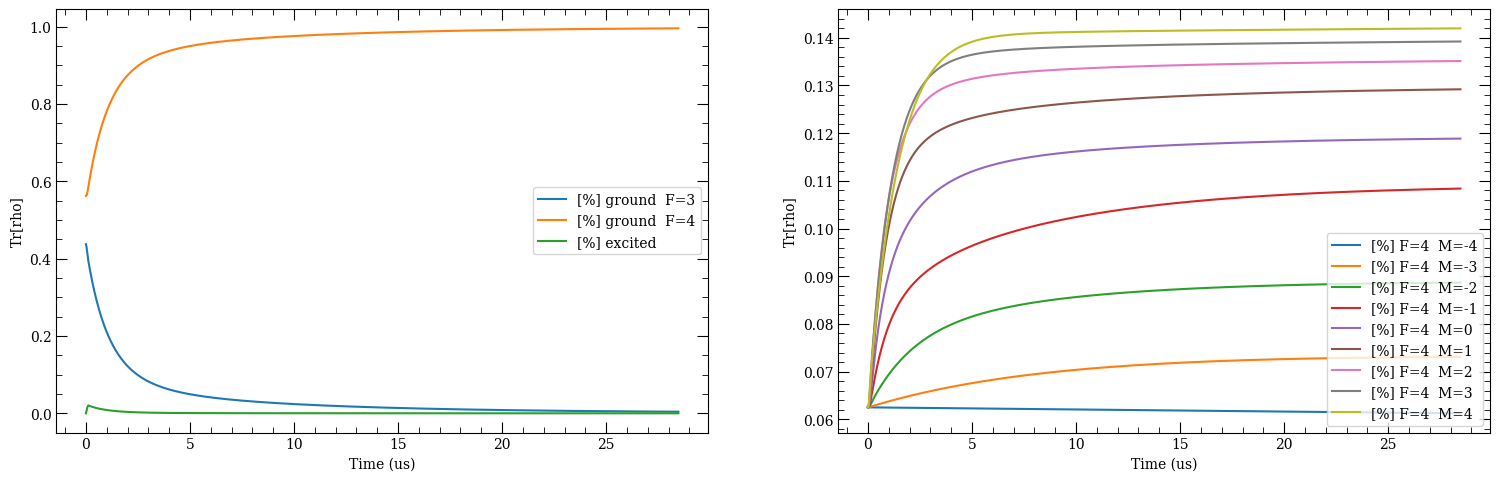

In [136]:
# print(population density on each hyperfine level)
# for i in range(0,len(t)):
#     [i]  = np.real(output.states[i].tr())
    
fig, ax = plt.subplots(1,2)
fig.set_size_inches(18.5, 5.5)
ax[0].plot(T*output.times*1e6, output.expect[0],label='[%] ground  F=3') 
ax[0].plot(T*output.times*1e6, output.expect[1],label='[%] ground  F=4') 
ax[0].plot(T*output.times*1e6, output.expect[2],label='[%] excited') 
# ax[0].plot(output.times, output.expect[3],label='<Jz>') 
# ax[0].plot(output.times, output.expect[4],label='<Jy>') 
ax[0].legend()
ax[0].set_xlabel('Time (us)') 
ax[0].set_ylabel('Tr[rho]') 

for i in range(5,14):
    ax[1].plot(T*output.times*1e6, output.expect[i],label='[%] F=4  M='+str(i-9)) 
ax[1].legend()
ax[1].set_xlabel('Time (us)') 
ax[1].set_ylabel('Tr[rho]') 
print(1e9*T)

Text(0.5, 0, 'Frequency')

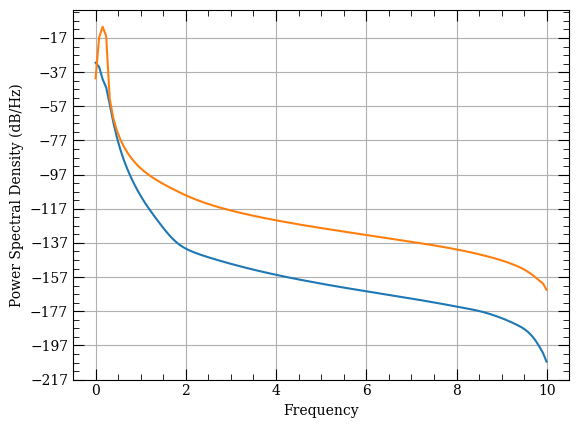

In [123]:
# plot Fourier transform of the result
Freqs = 1/(output.times[1] - output.times[0])
FFT_meanJy = plt.psd(output.expect[3],Fs=Freqs)
FFT_meanJz = plt.psd(output.expect[4],Fs=Freqs)
plt.xlabel('Frequency')